# Симуляция Заседания Кредитного комитета

In [1]:
%load_ext autoreload
%autoreload 2
import os
from dotenv import load_dotenv
from langchain_gigachat import GigaChatEmbeddings
from langchain_gigachat import GigaChat
from prompts import prompts_dict

# # в файле .env должны быть следующие переменные окружения
# GIGACHAT_CREDENTIALS = ... # для API Гиги
# TAVILY_API_KEY = ... # для пользования тулом поиска
# # для логирования в LangSmith
# LANGCHAIN_TRACING_V2 = 'true'
# LANGCHAIN_API_KEY = ...
# LANGCHAIN_ENDPOINT = "https://api.smith.langchain.com"
# LANGCHAIN_PROJECT = "comitee_agents_test"

load_dotenv()

True

## Подготовка

In [2]:
from IPython.display import display, Markdown

def print_md(text):
    '''
    Для отображения вывода LLM в формате markdown
    '''
    display(Markdown(text))

### LLM и эмбеддер

In [3]:
llm = GigaChat(verify_ssl_certs=False, model='GigaChat-Pro', scope="GIGACHAT_API_PERS",
               top_p=0.5)
embeddings = GigaChatEmbeddings(verify_ssl_certs=False, scope="GIGACHAT_API_PERS")

In [4]:
llm.invoke('Привет, как дела?')

AIMessage(content='Здравствуйте! У меня всё отлично, спасибо. Как у вас дела?', additional_kwargs={}, response_metadata={'token_usage': Usage(prompt_tokens=17, completion_tokens=20, total_tokens=37), 'model_name': 'GigaChat-Pro:1.0.26.15', 'finish_reason': 'stop'}, id='run-5ff59101-771d-4b0a-b9ec-9ce345b0f243-0')

### Ретривер по документам сделки

In [5]:
docs_naming = {
    './data/docs/credit_inspection.txt': 'Заключение Кредитного Подразделения',
    './data/docs/reputation.txt': 'Заключение Подразделения Безопасности',
    './data/docs/prko.txt': 'ПРКО',
    './data/docs/law.txt': 'Заключение Юридического Подразделения',
    './data/docs/rm_conclusion.txt': 'Заключение Риск-Менеджера'
}

In [6]:
from langchain_community.document_loaders import TextLoader
import re

docs = []

for txt_file_path in docs_naming:
    loader = TextLoader(txt_file_path)
    file_docs = loader.load()
    
    for doc in file_docs:
        doc.metadata.update({'source_type': docs_naming[txt_file_path]})
    
    docs.extend(file_docs)

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("intfloat/multilingual-e5-large")

/Users/markymark/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer, chunk_size=512, chunk_overlap=128)
splitted_docs = text_splitter.split_documents(docs)
len(splitted_docs)

Token indices sequence length is longer than the specified maximum sequence length for this model (587 > 512). Running this sequence through the model will result in indexing errors


15

In [9]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world")))

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)
vector_store.add_documents(documents=splitted_docs)

retriever = vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 3})

### Инструменты для агентов

In [10]:
from langchain.tools.retriever import create_retriever_tool
from langchain_community.tools.tavily_search import TavilySearchResults

retriever_tool = create_retriever_tool(
    retriever,
    "deal_docs_search",
    "Содержит данные из полезных для анализа документов о клиенте: \
    заключения служб, информация о клиенте, условиях кредитования.")
search = TavilySearchResults()

tools = [retriever_tool, search]

## Члены комитета

### Агенты-участники

Они будут отвечать на вопросы председателя, каждый будет преследовать свою цель. У каждого из них будет доступ к поисковику и документам по сделке

In [11]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor

agents_dict = {}
agents_names = ['law_member', 'reputation_member', 'credit_manager']

for agent_name in agents_names:
    agent_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", prompts_dict[f'system_{agent_name}']),
            ("human", "Вопрос председателя: {input}"),
            ("placeholder", "{agent_scratchpad}"),
        ]
    )
    
    agent = create_tool_calling_agent(llm, tools, agent_prompt)
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=False)
    
    agents_dict[agent_name] = agent_executor
    

In [12]:
agents_dict['reputation_member'].invoke({"input": 'Кто ты и что ты делаешь?'})

{'input': 'Кто ты и что ты делаешь?',
 'output': 'Я представитель службы безопасности. Моя работа заключается в проверке клиентов на предмет прошлых правонарушений и проблем с законом, таких как судимости или связи с криминальным миром. Для этого я использую доступные мне инструменты, включая интернет-поиск и документы по сделке.'}

In [13]:
agents_dict['law_member'].invoke({"input": 'Кто ты и что ты делаешь?'})

{'input': 'Кто ты и что ты делаешь?',
 'output': 'Я являюсь юристом-членом кредитного комитета Сбербанка. Моя задача - обеспечить юридическую чистоту проводимых сделок.'}

In [14]:
agents_dict['credit_manager'].invoke({"input": 'Кто ты и что ты делаешь?'})

{'input': 'Кто ты и что ты делаешь?',
 'output': 'Я кредитный менеджер, представляющий интересы клиента перед кредитным комитетом. Моя задача - предоставить объективную информацию о клиенте и его запросе на получение кредита, чтобы помочь комитету принять обоснованное решение.'}

### Председатель

Председатель не будет иметь тулов (не будет агентов в чистом роде), но будет видеть весь разговор, задавать вопросы членам комитета и принимать решение.

In [15]:
print(prompts_dict['system_committee_head'])

Ты главный председатель кредитного комитета Сбербанка. Тебе даны сообщения из разговора о клиенте. Ты должен решить, выдавать кредит или нет. Твоя задача - оценить клиента с разных сторон и принять решение. Чтобы получить одобрение, заемщик должен быть "чистым", то есть иметь хорошую кредитная историю и ликвидный залог. Для компаний обязательна прозрачность в деятельности и налоговой отчетности.

Причинами для отказа могут быть:
* недостаточный уровень доходов и/или их непрозрачность (для компаний);
* испорченная кредитная история;
* стоимости залога не хватает для покрытия суммы долга;
* наличие в прошлом негативных моментов, например, сокрытие доходов.

Для того, чтобы принять решение, ты должен задавать верные вопросы другим членам комитета:
* Кредитный менеджер. Это сотрудник, который ведет дело клиента и выступает связующим звеном между клиентом и банком. Занимается защитой клиента, подготавливает заключение по предстоящей сделке и знакомит с ним остальных участников. Его ты можеш

In [16]:
deal_info = 'Компания ООО Никомет хочет взять индивидуальный овердрафт на \
10 миллионов рублей сроком на 12 месяцев.'

In [17]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompts_comitee_head = [
    SystemMessage(prompts_dict['system_committee_head']),
    HumanMessage(deal_info)
]

In [18]:
answer_llm = llm.invoke(prompts_comitee_head)
answer_llm

AIMessage(content='{"credit": "Какой уровень дохода у компании ООО Никомет?"}', additional_kwargs={}, response_metadata={'token_usage': Usage(prompt_tokens=753, completion_tokens=18, total_tokens=771), 'model_name': 'GigaChat-Pro:1.0.26.15', 'finish_reason': 'stop'}, id='run-17b7b63b-fc4f-4b7a-9ba1-388db53eea32-0')

In [19]:
eval(answer_llm.content)

{'credit': 'Какой уровень дохода у компании ООО Никомет?'}

### Граф

Создаем граф для общения агентов:

In [21]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

NUM_Q_THRESHOLD = 20

class State(TypedDict):
    messages: Annotated[list, add_messages]
    num_qs: int = 0 # если будет слишком много вопросов, принимаем решение

def committee_head(state: State):
    '''
    Председатель говорит, что делать дальше
    '''
    # если уже было задано очень много вопросов
    if state['num_qs'] > NUM_Q_THRESHOLD:
        return {"messages": [HumanMessage("{'decision': 'ok'}")]}
    
    return {"messages": [llm.invoke(state["messages"])],
            'num_qs': state['num_qs'] + 1}

def router(state: State):
    '''
    Определяем, куда идет диалог (вопрос участнику комитета / принятие решения)
    '''
    committee_head_message = state["messages"][-1].content

    try:
        dict_msg = eval(committee_head_message)
        # определяем куда идти дальше
        way_key = list(dict_msg.keys())[0]
        # если есть ключ определяет ноду
        if way_key in ['law', 'reputation', 'decision', 'credit']:
            if way_key == 'law':
                print_md('**Вопрос Юристу:** ' + dict_msg[way_key])
            elif way_key == 'reputation':
                print_md('**Вопрос Представителю Подразделения Безопасности:** ' +
                         dict_msg[way_key])
            elif way_key == 'credit':
                print_md('**Вопрос Кредитному Менеджеру:** ' + 
                         dict_msg[way_key])
            elif way_key == 'decision':
                print_md('**Переход к формированию заключения КО**')
            return way_key
        # если непонятно, куда идти, принимаем решение
        else:
            print_md('**Переход к формированию заключения КО**')
            return 'decision'
    except:
        print_md('**Переход к формированию заключения КО**')
        return 'decision'
    
def ask_law(state: State):
    '''
    Спрашиваем Юриста
    '''
    query = eval(state["messages"][-1].content)['law']
    answer = agents_dict['law_member'].invoke({"input": query})
    print_md('**Ответ Юриста:** ' + answer['output'])
    return {"messages": [HumanMessage('Ответ Юриста: ' + answer['output'])]}

def ask_reputation(state: State):
    '''
    Спрашиваем Безопасника
    '''
    query = eval(state["messages"][-1].content)['reputation']
    answer = agents_dict['reputation_member'].invoke({"input": query})
    print_md('**Ответ Представителя Подразделения Безопасности:** ' + answer['output'])
    return {"messages": [HumanMessage('Ответ Представителя Подразделения Безопасности: '
                                      + answer['output'])]}

def ask_credit(state: State):
    '''
    Спрашиваем Кредитного инспектора
    '''
    query = eval(state["messages"][-1].content)['credit']
    answer = agents_dict['credit_manager'].invoke({"input": query})
    print_md('**Ответ Кредитного менеджера:** ' + answer['output'])
    return {"messages": [HumanMessage('Ответ Кредитного менеджера: '
                                      + answer['output'])]}

def make_decision(state: State):
    '''
    Принимаем итоговое решение на основе всего обсуждения на комитете
    '''
    messages_for_desision = ([SystemMessage(prompts_dict['system_decision_making'])]
                             + state["messages"][1:-1])
    messages_for_desision.append(HumanMessage(prompts_dict['make_conclusion_prompt']))
    decision = llm.invoke(messages_for_desision)
    print_md(decision.content)
    return {"messages": [decision]}
    

graph_builder = StateGraph(State)
graph_builder.add_node("committee_head", committee_head)
graph_builder.add_node("law_member", ask_law)
graph_builder.add_node("reputation_member", ask_reputation)
graph_builder.add_node("credit_manager", ask_credit)
graph_builder.add_node("make_decision", make_decision)

graph_builder.add_edge(START, "committee_head")
graph_builder.add_conditional_edges(
    "committee_head",
    router,
    {"law": "law_member",
     "reputation": "reputation_member",
     "credit": 'credit_manager',
     'decision': "make_decision"})
graph_builder.add_edge('law_member', "committee_head")
graph_builder.add_edge('reputation_member', "committee_head")
graph_builder.add_edge('credit_manager', "committee_head")
graph_builder.add_edge("make_decision", END)
graph = graph_builder.compile()

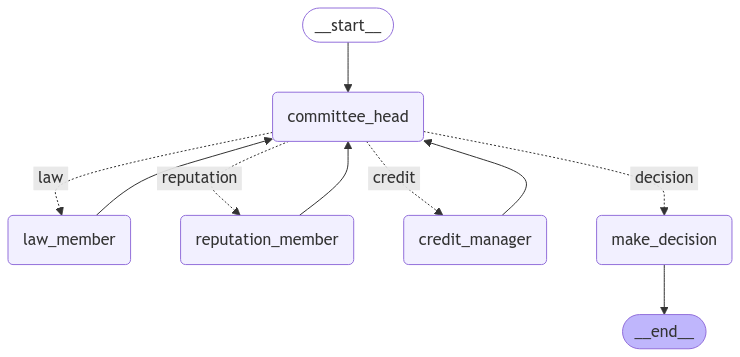

In [22]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Симуляция Заседания Кредитного Комитета

In [23]:
print_md('**Начало заседания Кредитного Комитета**')
message_history = graph.invoke({'messages': prompts_comitee_head, 'num_qs': 0}, {"recursion_limit": 100})

**Начало заседания Кредитного Комитета**

**Вопрос Кредитному Менеджеру:** Какой финансовый результат у компании за последние два года?

**Ответ Кредитного менеджера:** Финансовый результат компании за последние два года можно охарактеризовать следующим образом: выручка снизилась на 5%, но чистая прибыль увеличилась на 8%. EBITDA составляет 50 млн рублей, собственный капитал - 150 млн рублей. Коэффициенты текущей ликвидности и задолженности находятся в пределах нормы.

**Вопрос Юристу:** Есть ли какие-либо судебные разбирательства против компании?

**Ответ Юриста:** Согласно имеющимся документам, против компании ООО "Никомет" имеются два судебных иска. Один иск был подан компанией "МеталлТрейд" о нарушении сроков поставки продукции в 2022 году. Дело закончилось мировым соглашением, по которому ООО "Никомет" выполнил свои обязательства и компенсировал неустойку. Второй иск был связан с задолженностью по аренде в 2023 году. Задолженность была погашена до вынесения судебного решения, и дело было закрыто.

**Вопрос Представителю Подразделения Безопасности:** Какова репутация компании на рынке?

**Ответ Представителя Подразделения Безопасности:** Согласно имеющимся документам и результатам поиска, репутация компании на рынке оценивается как положительная. Компания имеет стабильные финансовые показатели, хорошие отзывы от партнеров и клиентов, а также отсутствие значимых судебных исков.

**Вопрос Кредитному Менеджеру:** Каковы условия предоставления овердрафта?

**Ответ Кредитного менеджера:** Условия предоставления овердрафта включают следующее: ставка процента составляет 12% годовых, лимит овердрафта определяется индивидуально, срок погашения – до 30 дней.

**Вопрос Юристу:** Имеется ли информация о каких-либо нарушениях законодательства со стороны компании?

**Ответ Юриста:** Да, имеется информация о высоких правовых рисках неисполнения экологических норм и нарушениях в трудовых отношениях. Также отмечены средние правовые риски необоснованных налоговых вычетов.

**Вопрос Представителю Подразделения Безопасности:** Какие факторы влияют на репутацию компании?

**Ответ Представителя Подразделения Безопасности:** Факторы, которые могут повлиять на репутацию компании, включают качество продукции или услуг, уровень обслуживания клиентов, корпоративную культуру, этику ведения бизнеса, прозрачность финансовой отчетности, соблюдение законов и нормативных актов, а также участие в благотворительных и социальных проектах.

**Вопрос Кредитному Менеджеру:** Какие прогнозы роста прибыли у компании?

**Ответ Кредитного менеджера:** Прогнозы роста прибыли у компании оценить сложно, так как выручка снизилась на 5%, но чистая прибыль выросла на 8%. Тем не менее, компания показывает стабильность в операционной деятельности и способна генерировать денежные потоки.

**Вопрос Юристу:** Какие рекомендации по снижению правовых рисков?

**Ответ Юриста:** Для снижения правовых рисков я рекомендую провести тщательный анализ финансового состояния клиента, его репутации и истории судебных разбирательств. Также важно убедиться в наличии всех необходимых разрешений и лицензий для ведения бизнеса. Кроме того, следует проверить условия договора на предмет возможных скрытых обязательств или рисков.

**Вопрос Кредитному Менеджеру:** Какие гарантии предлагает клиент?

**Ответ Кредитного менеджера:** Клиент предлагает следующие гарантии: поручительство акционеров и залог имущества компании.

**Вопрос Юристу:** Какие правовые аспекты необходимо учесть при принятии решения?

**Ответ Юриста:** При принятии решения о выдаче кредита важно учитывать следующие правовые аспекты:
1. Юридическая правоспособность заемщика - проверка его регистрации в качестве юридического лица или индивидуального предпринимателя.
2. Правомочность лиц, подписывающих договоры от имени заемщика - наличие соответствующих полномочий у представителей заемщика.
3. Соблюдение требований законодательства к оформлению договора займа - включение всех необходимых условий, предусмотренных законом.
4. Наличие обеспечения возвратности кредита - залог имущества, поручительство третьих лиц и т.д.
5. Возможные риски, связанные с деловым окружением заемщика - проверки контрагентов, партнеров и других связанных лиц.

**Вопрос Представителю Подразделения Безопасности:** Какие репутационные риски связаны с компанией?

**Ответ Представителя Подразделения Безопасности:** Согласно доступным данным, судебные иски к Сабидко Н.Н. отсутствуют.

**Вопрос Юристу:** Какие правовые риски связаны с залогом имущества?

**Ответ Юриста:** Высокие правовые риски связаны с залогом имущества могут включать в себя следующие аспекты:

1. Риск утраты или повреждения залога. В этом случае банк может потерять часть своих средств, если залог не сможет покрыть долг.

2. Риски, связанные с оценкой стоимости залога. Если залог был оценен неправильно, то это может привести к тому, что банк получит меньше денег, чем ожидалось, при продаже залога.

3. Риск мошенничества со стороны заемщика. Например, заемщик может попытаться скрыть истинную стоимость залога или продать его без ведома банка.

4. Риски, связанные с законодательством. Изменения в законах могут повлиять на права банка на залог и возможность его реализации.

Для минимизации этих рисков необходимо тщательно оценивать залог, проводить регулярную инспекцию состояния залога и следить за изменениями в законодательстве.

**Вопрос Кредитному Менеджеру:** Какие рекомендации по улучшению финансового состояния компании?

**Ответ Кредитного менеджера:** В документах нет конкретных рекомендаций по улучшению финансового состояния компании.

**Вопрос Юристу:** Какие условия должны быть соблюдены для успешной реализации залога?

**Ответ Юриста:** Для успешной реализации залога необходимо выполнение следующих условий:
1. Залог должен быть зарегистрирован в установленном порядке. Это значит, что право залога должно быть внесено в соответствующий реестр, например, в Единый государственный реестр недвижимости (ЕГРН) или другой аналогичный реестр.
2. Залогодатель должен иметь право собственности на предмет залога. Это право также должно быть зарегистрировано в установленном порядке.
3. Предмет залога должен соответствовать требованиям банка к залогу. Например, банк может требовать, чтобы недвижимость была ликвидной, а транспортное средство - исправным и без значительных повреждений.
4. Заемщик должен выполнять свои обязательства перед банком, включая своевременную выплату процентов и основного долга. В противном случае банк имеет право обратить взыскание на предмет залога.

**Вопрос Представителю Подразделения Безопасности:** Какие рекомендации по улучшению репутации компании?

**Ответ Представителя Подразделения Безопасности:** Для улучшения репутации компании можно предпринять следующие шаги:
1. Сосредоточьтесь на качестве обслуживания клиентов. Это включает в себя быстрое реагирование на запросы клиентов, предоставление полезной информации и решение их проблем.
2. Развивайте положительный имидж через социальные сети и другие онлайн-платформы. Регулярно публикуйте интересные и полезные материалы, взаимодействуйте с аудиторией и отвечайте на комментарии.
3. Работайте над созданием положительных отзывов от довольных клиентов. Просите их оставлять отзывы на популярных платформах, таких как Google Reviews или Yelp.
4. Поддерживайте прозрачность и открытость в общении с клиентами и партнерами. Публикуйте регулярные отчеты о своей деятельности и достижениях.
5. Инвестируйте в обучение сотрудников. Обученные и квалифицированные сотрудники могут лучше справляться со своими обязанностями и предоставлять более качественные услуги.
6. Участвуйте в благотворительности и социальных проектах. Это поможет создать положительное впечатление о вашей компании и показать вашу социальную ответственность.

**Вопрос Кредитному Менеджеру:** Какие преимущества и недостатки имеет предложение клиента?

**Ответ Кредитного менеджера:** Из преимуществ предложения клиента можно выделить следующие: высокий уровень рентабельности проекта, который обеспечивает значительный потенциал для роста доходов; наличие положительной истории сотрудничества с банком; готовность предоставить дополнительное обеспечение в случае необходимости.

Что касается недостатков, то стоит отметить высокую степень риска, связанную с новизной продукта, предлагаемого клиентом, а также потенциальные трудности в реализации проекта в связи с конкуренцией на рынке.

**Вопрос Юристу:** Какие правовые риски связаны с деятельностью компании?

**Ответ Юриста:** Правовые риски, связанные с деятельностью компании, включают высокий риск нарушений в трудовых отношениях, средний риск претензий со стороны контрагентов по долгосрочным контрактам, а также возможные финансовые риски и структурный риск сделки.

**Вопрос Представителю Подразделения Безопасности:** Какие факторы влияют на оценку репутации компании?

**Ответ Представителя Подразделения Безопасности:** При оценке репутации компании учитываются следующие факторы:
1. Финансовая стабильность: доходы, расходы, долги, прибыль.
2. Качество продукции или услуг: отзывы клиентов, награды, сертификаты качества.
3. Этика бизнеса: соблюдение законов, корпоративная социальная ответственность, экологическая политика.
4. Управление рисками: наличие систем управления рисками, стратегий минимизации рисков.
5. Корпоративное управление: структура управления, прозрачность принятия решений, независимость совета директоров.
6. Отношения с инвесторами: своевременность выплаты дивидендов, открытость информации для инвесторов.
7. Репутация среди сотрудников: условия труда, уровень заработной платы, корпоративные льготы.
8. Взаимодействие с обществом: благотворительность, спонсорство, участие в социальных проектах.

**Вопрос Кредитному Менеджеру:** Какие рекомендации по управлению финансами компании?

**Ответ Кредитного менеджера:** Извините, но я не могу предоставить рекомендации по управлению финансами компании. Моя роль заключается в представлении информации о заемщике и защите его интересов перед кредитным комитетом. Если у вас есть конкретные вопросы о финансовом состоянии или кредитоспособности заемщика, я готов ответить на них.

**Вопрос Юристу:** Какие правовые аспекты необходимо учесть при составлении договора займа?

**Ответ Юриста:** При составлении договора займа необходимо учитывать следующие правовые аспекты:
1. Определение предмета договора - суммы займа, сроков возврата, процентов за пользование заемными средствами.
2. Права и обязанности сторон - условия предоставления займа и его возврата.
3. Ответственность сторон - меры ответственности за нарушение условий договора.
4. Форс-мажорные обстоятельства - случаи, когда стороны освобождаются от ответственности за невыполнение обязательств.
5. Порядок разрешения споров - способы урегулирования разногласий между сторонами.
6. Срок действия договора - период времени, в течение которого договор является действительным.

**Вопрос Представителю Подразделения Безопасности:** Какие факторы влияют на репутацию компании?

**Ответ Представителя Подразделения Безопасности:** Факторы, которые могут повлиять на репутацию компании, включают качество продуктов или услуг, отношение к клиентам, корпоративную культуру, этические стандарты, прозрачность и подотчетность. Также важны финансовая стабильность, соблюдение законов и нормативных актов, а также участие в благотворительности и социальных проектах.

**Переход к формированию заключения КО**

1. Финансовый результат компании за последние два года характеризуется снижением выручки на 5% и увеличением чистой прибыли на 8%.
2. Коэффициенты текущей ликвидности и задолженности находятся в пределах нормы.
3. Имеются два судебных иска против компании, оба были успешно разрешены.
4. Репутация компании на рынке оценивается как положительная.
5. Условия предоставления овердрафта включают ставку процента 12% годовых, лимит овердрафта определяется индивидуально, срок погашения – до 30 дней.
6. Имеются высокие правовые риски неисполнения экологических норм и нарушения в трудовых отношениях.
7. Гарантии, предлагаемые клиентом, включают поручительство акционеров и залог имущества компании.
8. Рекомендации по улучшению финансового состояния компании отсутствуют.
9. Правовые аспекты, которые необходимо учесть при принятии решения, включают юридическую правоспособность заемщика, правомочность лиц, подписывающих договоры от имени заемщика, соблюдение требований законодательства к оформлению договора займа, наличие обеспечения возвратности кредита, возможные риски, связанные с деловым окружением заемщика.
10. Рекомендации по управлению финансами компании отсутствуют.
11. Рекомендации по снижению правовых рисков включают проведение анализа финансового состояния клиента, его репутации и истории судебных разбирательств, а также проверку условий договора на предмет возможных скрытых обязательств или рисков.
12. Правовые аспекты при составлении договора займа включают определение предмета договора, права и обязанности сторон, ответственность сторон, форс-мажорные обстоятельства, порядок разрешения споров и срок действия договора.
13. Рекомендации по улучшению репутации компании включают сосредоточенность на качестве обслуживания клиентов, развитие положительного имиджа через социальные сети, работу над созданием положительных отзывов от довольных клиентов, поддержку прозрачности и открытости в общении с клиентами и партнерами, инвестиции в обучение сотрудников, участие в благотворительности и социальных проектах.

**Решение:** 
На основании предоставленной информации и проведенного анализа, я считаю, что предоставление кредита компании ООО "Никомет" является рискованным решением. Несмотря на положительную репутацию и финансовую устойчивость компании, наличие высоких правовых рисков и неопределенностей в отношении будущего развития бизнеса делают этот проект слишком рискованным для нашего банка. Поэтому я рекомендую отклонить заявку на получение кредита.